In [1]:
# Import Libraries

import pandas as pd
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report


In [2]:
# Load Dataset

df = pd.read_csv("Tweets.csv")
df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
# Clean tweet text

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'@\w+', '', text)     # remove mentions
    text = re.sub(r'#\w+', '', text)     # remove hashtags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

df['clean_text'] = df['text'].astype(str).apply(clean_text)
df[['text', 'clean_text']].head()



,text,clean_text
0,@VirginAmerica What @dhepburn said.,what said
1,@VirginAmerica plus you've added commercials t...,plus youve added commercials to the experience...
2,@VirginAmerica I didn't today... Must mean I n...,i didnt today must mean i need to take another...
3,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...
4,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it


In [7]:
# TF- IDF Feature Extraction

vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['airline_sentiment']


In [9]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [11]:
# Train and Evaluate Model

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))



Model: Naive Bayes
Accuracy: 0.7558060109289617
              precision    recall  f1-score   support

    negative       0.75      0.97      0.85      1889
     neutral       0.72      0.27      0.39       580
    positive       0.85      0.47      0.61       459

    accuracy                           0.76      2928
   macro avg       0.77      0.57      0.62      2928
weighted avg       0.76      0.76      0.72      2928


Model: Logistic Regression
Accuracy: 0.7954234972677595
              precision    recall  f1-score   support

    negative       0.82      0.94      0.87      1889
     neutral       0.66      0.48      0.55       580
    positive       0.80      0.62      0.70       459

    accuracy                           0.80      2928
   macro avg       0.76      0.68      0.71      2928
weighted avg       0.79      0.80      0.78      2928


Model: Linear SVM
Accuracy: 0.7855191256830601
              precision    recall  f1-score   support

    negative       0.84      

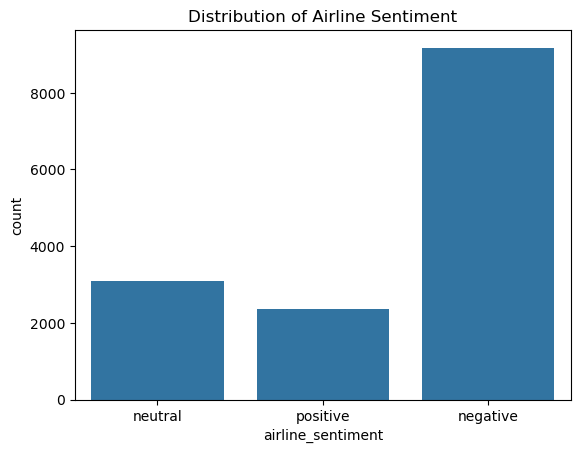

In [13]:
# Visualization

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='airline_sentiment', data=df)
plt.title("Distribution of Airline Sentiment")
plt.show()


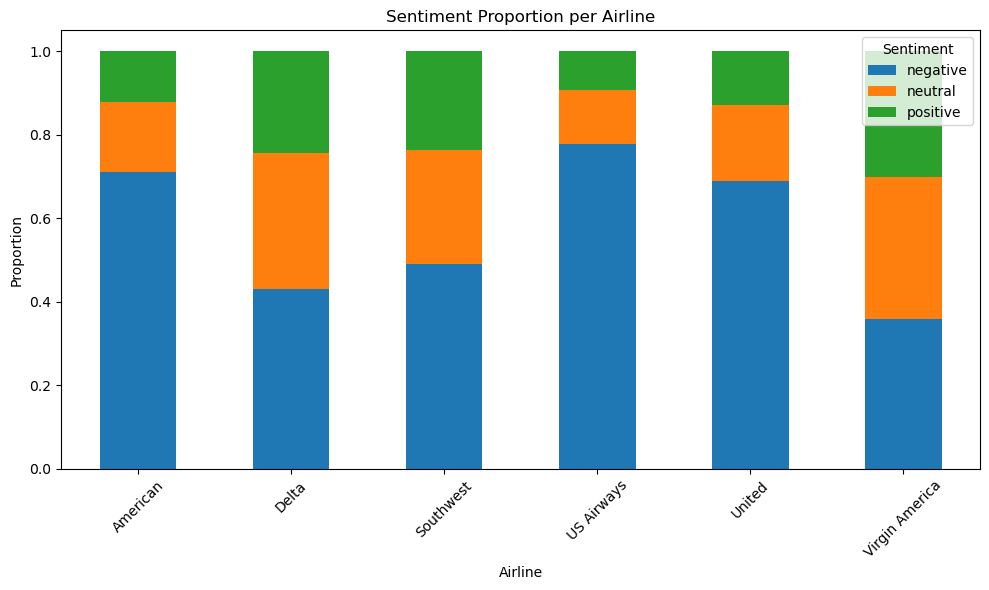

In [15]:
# 4. Sentiment Distribution per Airline (Stacked Bar Plot)
sentiment_counts = df.groupby(['airline', 'airline_sentiment']).size().unstack().fillna(0)

# Normalize by row to get percentage
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Plot
sentiment_proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Sentiment Proportion per Airline")
plt.xlabel("Airline")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


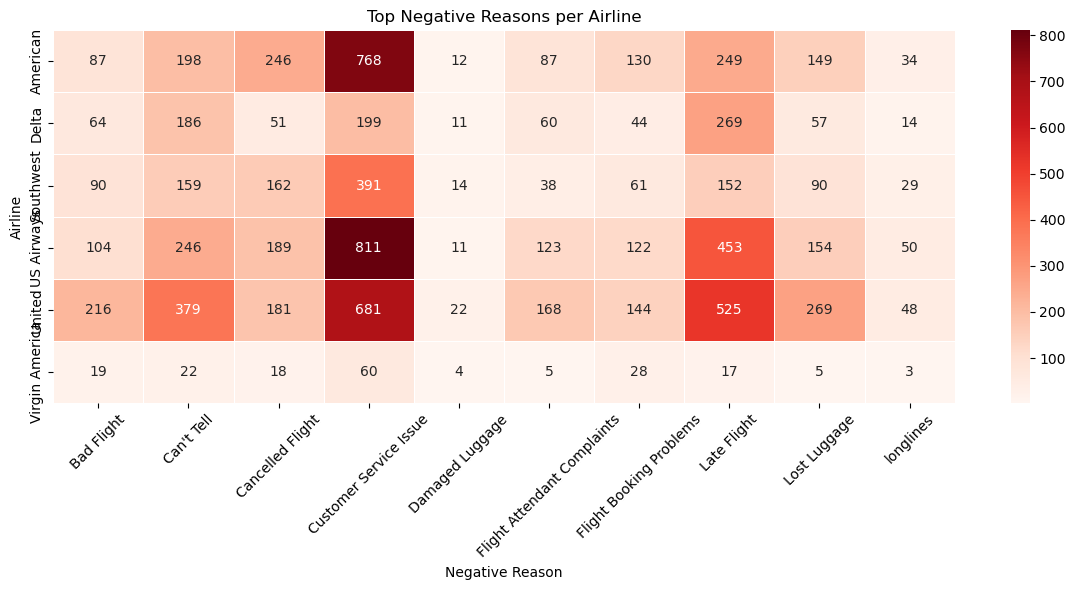

In [20]:
###### 5. Top Negative Reasons per Airline (Heatmap)

# Filter only negative tweets with valid reason
negatives = df[(df['airline_sentiment'] == 'negative') & (df['negativereason'].notnull())]

# Count of negative reasons grouped by airline
neg_reason_counts = negatives.groupby(['airline', 'negativereason']).size().unstack().fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(neg_reason_counts, annot=True, fmt='g', cmap='Reds', linewidths=0.5)
plt.title("Top Negative Reasons per Airline")
plt.xlabel("Negative Reason")
plt.ylabel("Airline")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
